In [12]:
import ee
import geemap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import geopandas as gpd
import json
import os
#ee.Authenticate()

# Inicializar la API de Earth Engine
ee.Initialize(project='curso-colombia-467723')
# Crear un mapa interactivo
Map = geemap.Map()



# Ruta a tu archivo GeoJSON en Google Drive
geojson_path = '/home/irm/proyectos/puntos_entrenamiento_combinados2.geojson'

# Leer el archivo GeoJSON usando geopandas
gdf = gpd.read_file(geojson_path)

# Imprimir información básica sobre los puntos de entrenamiento
print(f"Total de puntos de entrenamiento: {len(gdf)}")
print("Distribución de clases:")
print(gdf['clase'].value_counts())

Total de puntos de entrenamiento: 1750
Distribución de clases:
clase
urbano        250
vegetacion    250
cultivos      250
nieve         250
agua          250
suelo         250
suelo2        250
Name: count, dtype: int64


In [13]:
# Definir el área de interés (ROI)

roi = ee.FeatureCollection('projects/curso-colombia-467723/assets/Nuble_comunas_')


# Centrar el mapa en el ROI
Map.centerObject(roi, 10)

In [14]:
# Definir años de interés y clases
años = [2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]

# Definir las clases para la clasificación (usando los valores del GeoJSON)
clases = {
    'urbano': {'color': '#ff0000', 'clase': 0},
    'vegetacion': {'color': '#00ff00', 'clase': 1},
    'cultivos': {'color': '#ffff00', 'clase': 2},
    'nieve': {'color': '#ffffff', 'clase': 3},
    'agua': {'color': '#0000ff', 'clase': 4},
    'suelo': {'color': '#ff9900', 'clase': 5},
    'suelo2': {'color': '#994c00', 'clase': 6}
}

# Función corregida para convertir GeoJSON a FeatureCollection de Earth Engine
def geojson_to_ee(geojson_path, clases_dict):
    """
    Convierte un archivo GeoJSON en un FeatureCollection de Earth Engine
    y convierte los nombres de clase en valores numéricos.

    Args:
        geojson_path: Ruta al archivo GeoJSON
        clases_dict: Diccionario que mapea nombres de clase a valores numéricos

    Returns:
        ee.FeatureCollection con los puntos de entrenamiento
    """
    # Crear un mapeo inverso de nombres de clase a valores numéricos
    clase_a_numero = {k: v['clase'] for k, v in clases_dict.items()}

    # Leer el archivo GeoJSON
    with open(geojson_path, 'r') as f:
        geojson_data = json.load(f)

    # Convertir características a formato EE
    features = []
    for feature in geojson_data['features']:
        geometry = feature['geometry']
        properties = feature['properties'].copy()

        # Convertir el valor de clase de texto a número si es necesario
        if 'clase' in properties and isinstance(properties['clase'], str):
            clase_texto = properties['clase'].lower()  # Convertir a minúsculas para consistencia
            if clase_texto in clase_a_numero:
                properties['clase'] = clase_a_numero[clase_texto]
            else:
                print(f"ADVERTENCIA: Clase '{properties['clase']}' no reconocida. Asegúrate de que coincida con una de las clases definidas.")

        # Crear feature de EE
        ee_feature = ee.Feature(
            ee.Geometry.Point(geometry['coordinates']),
            properties
        )
        features.append(ee_feature)

    # Crear FeatureCollection
    return ee.FeatureCollection(features)

# Convertir GeoJSON a FeatureCollection con conversión de clases
puntosTrain = geojson_to_ee(geojson_path, clases)

# Verificar número de puntos en el FeatureCollection
print(f"Número de puntos en Earth Engine: {puntosTrain.size().getInfo()}")

# Definir el área de interés (ROI) basado en el extent del GeoJSON
bbox = gdf.total_bounds  # [xmin, ymin, xmax, ymax]
roi = ee.Geometry.Rectangle([bbox[0], bbox[1], bbox[2], bbox[3]])

# Centrar el mapa en el ROI
Map.centerObject(roi, 10)
Map.addLayer(roi, {}, 'Área de interés')

Número de puntos en Earth Engine: 1750


In [15]:
# Función para dividir FeatureCollection en k-folds
def kFoldSplit(features, k):
    """
    Divide una colección de características en k pliegues para validación cruzada.

    Args:
        features: ee.FeatureCollection con los puntos de entrenamiento
        k: Número de pliegues para la validación cruzada

    Returns:
        ee.FeatureCollection con los pliegues para entrenamiento y validación
    """
    step = ee.Number(1).divide(k)
    thresholds = ee.List.sequence(0, ee.Number(1).subtract(step), step)

    # Añadir columna aleatoria para la división
    features = features.randomColumn(seed=42)

    # Crear los pliegues
    def create_fold(threshold):
        threshold = ee.Number(threshold)

        # Filtrar para obtener conjunto de entrenamiento
        trainingSplit = features.filter(
            ee.Filter.Or(
                ee.Filter.lt('random', threshold),
                ee.Filter.gte('random', threshold.add(step))
            )
        )

        # Filtrar para obtener conjunto de validación
        validationSplit = features.filter(
            ee.Filter.And(
                ee.Filter.gte('random', threshold),
                ee.Filter.lt('random', threshold.add(step))
            )
        )

        return ee.Feature(None, {
            'training': trainingSplit,
            'validation': validationSplit
        })

    splits = thresholds.map(lambda t: create_fold(t))
    return ee.FeatureCollection(splits)

# Función para calcular y mostrar la importancia de variables (índice Gini)
def calcularImportanciaGini(classifier, bands):
    """
    Calcula y muestra la importancia de variables basada en el índice Gini.

    Args:
        classifier: Clasificador entrenado de Earth Engine
        bands: Lista de bandas utilizadas en la clasificación

    Returns:
        Diccionario con la importancia de cada variable
    """
    # Obtener la importancia de variables del clasificador
    importance = classifier.explain().get('importance')

    # Convertir a formato utilizable en Python
    importance_dict = importance.getInfo()

    # Crear DataFrame para visualización
    importance_df = pd.DataFrame({
        'Variable': list(importance_dict.keys()),
        'Importancia': list(importance_dict.values())
    })
    importance_df = importance_df.sort_values('Importancia', ascending=False)

    # Mostrar resultados
    print('Importancia de variables (basada en reducción de impureza Gini):')
    display(importance_df)

    # Crear gráfico de barras
    plt.figure(figsize=(10, 6))
    plt.bar(importance_df['Variable'], importance_df['Importancia'])
    plt.title('Importancia de variables basada en índice Gini')
    plt.xlabel('Variable')
    plt.ylabel('Importancia (reducción de impureza Gini)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return importance

In [16]:
# Función para visualizar detalladamente la matriz de confusión (corregida)
def mostrarMatrizConfusion(matriz, nombreClases):
    """
    Visualiza detalladamente la matriz de confusión y métricas asociadas.

    Args:
        matriz: Matriz de confusión de Earth Engine
        nombreClases: Lista con nombres de las clases

    Returns:
        Diccionario con la matriz y métricas
    """
    # Obtener la matriz como array
    matrizArray = matriz.array().getInfo()

    # Calcular métricas por clase
    precision = matriz.producersAccuracy().getInfo()
    recall = matriz.consumersAccuracy().getInfo()

    # Crear DataFrame para mejor visualización
    matriz_df = pd.DataFrame(matrizArray,
                            index=nombreClases,
                            columns=nombreClases)

    print('Matriz de Confusión:')
    display(matriz_df)

    # Preparar los datos según el formato devuelto (lista o diccionario)
    if isinstance(precision, dict):
        precision_values = list(precision.values())
    else:  # Si es una lista u otro iterable
        precision_values = precision

    if isinstance(recall, dict):
        recall_values = list(recall.values())
    else:  # Si es una lista u otro iterable
        recall_values = recall

    # Asegurarnos de tener suficientes valores
    while len(precision_values) < len(nombreClases):
        precision_values.append(None)
    while len(recall_values) < len(nombreClases):
        recall_values.append(None)

    # Crear DataFrames para métricas
    precision_df = pd.DataFrame({
        'Clase': nombreClases,
        'Precisión (Producer\'s Accuracy)': precision_values[:len(nombreClases)]
    })

    recall_df = pd.DataFrame({
        'Clase': nombreClases,
        'Exhaustividad (Consumer\'s Accuracy/Recall)': recall_values[:len(nombreClases)]
    })

    # Mostrar métricas
    print('\nPrecisión por clase (Producer\'s Accuracy):')
    display(precision_df)

    print('\nExhaustividad por clase (Consumer\'s Accuracy/Recall):')
    display(recall_df)

    # Otros estadísticos de interés
    print(f"\nExactitud global (Overall Accuracy): {matriz.accuracy().getInfo():.4f}")
    print(f"Coeficiente Kappa: {matriz.kappa().getInfo():.4f}")

    return {
        'matriz': matriz,
        'precision': precision,
        'recall': recall
    }

# Función para realizar la validación cruzada
def realizarValidacionCruzada(imagen, puntosTrain, bands, numFolds, nombreClases):
    """
    Realiza validación cruzada para evaluar el rendimiento del clasificador.

    Args:
        imagen: Imagen de Earth Engine con las bandas para clasificación
        puntosTrain: Puntos de entrenamiento
        bands: Lista de bandas a utilizar
        numFolds: Número de pliegues para validación cruzada
        nombreClases: Lista con nombres de las clases

    Returns:
        Diccionario con los resultados de la validación cruzada
    """
    folds = kFoldSplit(puntosTrain, numFolds)

    def procesarFold(fold):
        # Obtener conjuntos de entrenamiento y validación
        trainingPoints = ee.FeatureCollection(fold.get('training'))
        validationPoints = ee.FeatureCollection(fold.get('validation'))

        # Muestrear regiones para entrenamiento
        training = imagen.select(bands).sampleRegions(
            collection=trainingPoints,
            properties=['clase'],
            scale=30,
            tileScale=16
        )

        # Entrenar el clasificador
        classifier = ee.Classifier.smileRandomForest(
            numberOfTrees=100,
            minLeafPopulation=10
        ).train(
            features=training,
            classProperty='clase',
            inputProperties=bands
        )

        # Muestrear regiones para validación
        validation = imagen.select(bands).sampleRegions(
            collection=validationPoints,
            properties=['clase'],
            scale=30,
            tileScale=16
        )

        # Calcular matriz de confusión
        confMatrix = validation.classify(classifier).errorMatrix('clase', 'classification')

        return ee.Feature(None, {
            'accuracy': confMatrix.accuracy(),
            'kappa': confMatrix.kappa(),
            'matrix': confMatrix
        })

    # Aplicar la función a cada pliegue
    accuracies = ee.FeatureCollection(folds.map(procesarFold))

    # Obtener valores de precisión y kappa
    accuracyValues = accuracies.aggregate_array('accuracy').getInfo()
    kappaValues = accuracies.aggregate_array('kappa').getInfo()

    # Calcular promedios
    meanAccuracy = accuracies.aggregate_mean('accuracy').getInfo()
    meanKappa = accuracies.aggregate_mean('kappa').getInfo()

    # Imprimir resultados
    print('Resultados de la Validación Cruzada:')
    print(f'Accuracies por fold: {accuracyValues}')
    print(f'Kappas por fold: {kappaValues}')
    print(f'Accuracy promedio: {meanAccuracy:.4f}')
    print(f'Kappa promedio: {meanKappa:.4f}')

    return {
        'accuracies': accuracyValues,
        'kappas': kappaValues,
        'meanAccuracy': meanAccuracy,
        'meanKappa': meanKappa
    }

In [17]:
# Función para procesar y clasificar un año específico
def clasificarAño(año):
    """
    Procesa y clasifica imágenes de un año específico.

    Args:
        año: Año a procesar

    Returns:
        Imagen clasificada con el año como propiedad
    """
    # Definir fechas para el año actual
    startDate = ee.Date.fromYMD(año, 1, 1)
    endDate = ee.Date.fromYMD(año, 12, 31)

    # Cargar colección Landsat y preprocesar
    collection = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
        .filterBounds(roi) \
        .filterDate(startDate, endDate) \
        .filter(ee.Filter.lt('CLOUD_COVER', 20))

    print(f"Número de imágenes para el año {año}: {collection.size().getInfo()}")

    # Si no hay imágenes para este año, devolver None
    if collection.size().getInfo() == 0:
        print(f"No hay imágenes disponibles para el año {año}")
        return None

    # Función para renombrar bandas
    def renameBands(image):
        return image.select(
            ['SR_B2', 'SR_B3', 'SR_B4', 'SR_B5', 'SR_B6', 'SR_B7'],
            ['blue', 'green', 'red', 'nir', 'swir1', 'swir2']
        )

    # Crear compuesto anual
    landsatImage = collection.map(renameBands).median()
         # Obtener datos de elevación y pendiente
    dem = ee.Image('CGIAR/SRTM90_V4')
    elevation = dem.select('elevation')
    slope = ee.Terrain.slope(dem).rename('slope')

    # Calcular índices espectrales
    ndvi = landsatImage.normalizedDifference(['nir', 'red']).rename('ndvi')
    ndwi = landsatImage.normalizedDifference(['green', 'nir']).rename('ndwi')
    ndsi = landsatImage.normalizedDifference(['green', 'swir1']).rename('ndsi')


    # Combinar imagen con índices y datos topográficos
    imageWithIndices = landsatImage.addBands(ndvi).addBands(ndwi).addBands(ndsi).addBands(elevation).addBands(slope)

    # Definir bandas para el clasificador
    bands = ['blue', 'green', 'red', 'nir', 'swir1', 'swir2', 'ndvi', 'ndwi', 'ndsi','elevation','slope']

    # Definir los nombres de las clases para la matriz de confusión
    nombreClases = ['Urbano', 'Vegetación', 'Cultivos', 'Nieve', 'Agua', 'Suelo', 'Suelo 2']

    # Realizar validación cruzada
    print(f"\n=== Validación cruzada para el año {año} ===")
    resultadosCV = realizarValidacionCruzada(imageWithIndices, puntosTrain, bands, 5, nombreClases)

    # Entrenar el clasificador final con todos los datos
    training = imageWithIndices.select(bands).sampleRegions(
        collection=puntosTrain,
        properties=['clase'],
        scale=30,
        tileScale=16
    )

    classifier = ee.Classifier.smileRandomForest(
        numberOfTrees=100,
        minLeafPopulation=10
    ).train(
        features=training,
        classProperty='clase',
        inputProperties=bands
    )

    # Calcular importancia de variables (índice Gini)
    print(f'\n=== Importancia de variables para el año {año} ===')
    importancia = calcularImportanciaGini(classifier, bands)

    # Clasificar la imagen
    classified = imageWithIndices.select(bands).classify(classifier)

    # Evaluar el modelo con los datos de entrenamiento
    trainAccuracy = training.classify(classifier).errorMatrix('clase', 'classification')

    # Mostrar matriz de confusión detallada
    print(f'\n=== Matriz de confusión para el año {año} ===')
    matrizResultados = mostrarMatrizConfusion(trainAccuracy, nombreClases)

    # Recortar la clasificación al área de estudio
    classifiedROI = classified.clip(roi)

    # Devolver la imagen clasificada con el año como propiedad
    return classifiedROI.set('year', año)

Número de imágenes para el año 2013: 39

=== Validación cruzada para el año 2013 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9042253521126761, 0.9101449275362319, 0.9430199430199431, 0.9255952380952381, 0.9173553719008265]
Kappas por fold: [0.8882241813602015, 0.8951840526872868, 0.9332274357242731, 0.9131208241110399, 0.9033640663407017]
Accuracy promedio: 0.9201
Kappa promedio: 0.9066

=== Importancia de variables para el año 2013 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,53.114887
8,slope,32.609191
2,green,21.145018
0,blue,20.297503
7,red,18.995850
5,ndwi,16.998520
4,ndvi,16.559480
10,swir2,15.473468
3,ndsi,14.414523
6,nir,11.834875


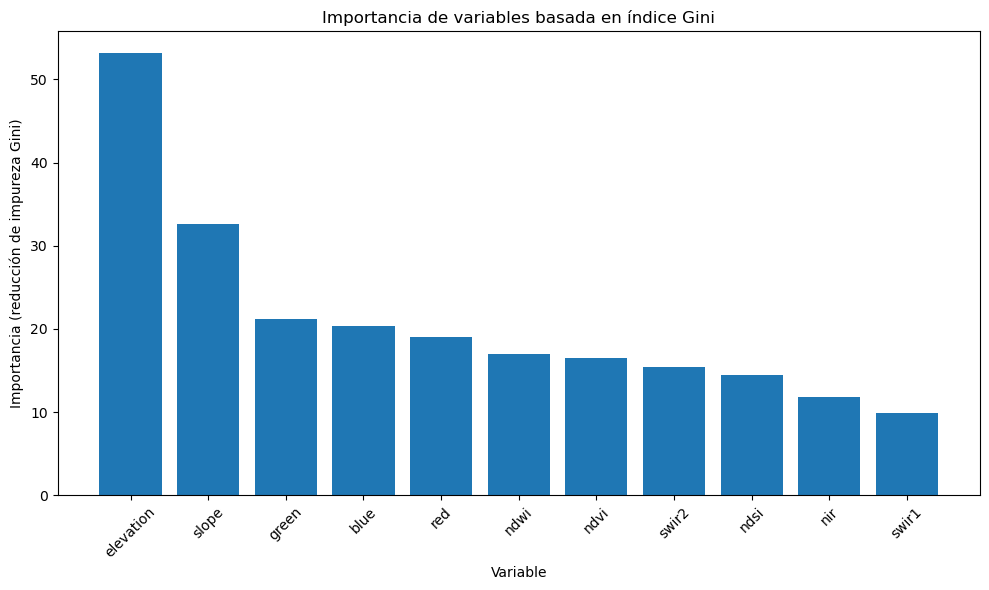


=== Matriz de confusión para el año 2013 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,235,1,14,0,0,0,0
Vegetación,2,229,5,0,0,13,1
Cultivos,7,3,240,0,0,0,0
Nieve,0,0,0,248,0,0,2
Agua,1,3,3,0,243,0,0
Suelo,1,16,5,0,0,227,1
Suelo 2,0,13,0,5,5,0,227



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.94]
1,Vegetación,[0.916]
2,Cultivos,[0.96]
3,Nieve,[0.992]
4,Agua,[0.972]
5,Suelo,[0.908]
6,Suelo 2,[0.908]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9552845528455285, 0.8641509433962264, 0.898..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9423
Coeficiente Kappa: 0.9327
Número de imágenes para el año 2014: 60

=== Validación cruzada para el año 2014 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9408450704225352, 0.9246376811594202, 0.9458689458689459, 0.9285714285714286, 0.9146005509641874]
Kappas por fold: [0.9309581581433255, 0.912070892230478, 0.936627547869055, 0.9165726936963966, 0.9002561625258158]
Accuracy promedio: 0.9309
Kappa promedio: 0.9193

=== Importancia de variables para el año 2014 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,57.546670
8,slope,31.425802
2,green,22.497768
7,red,18.193507
10,swir2,16.788261
4,ndvi,16.566904
5,ndwi,16.419028
0,blue,15.436356
9,swir1,14.981843
6,nir,13.670191


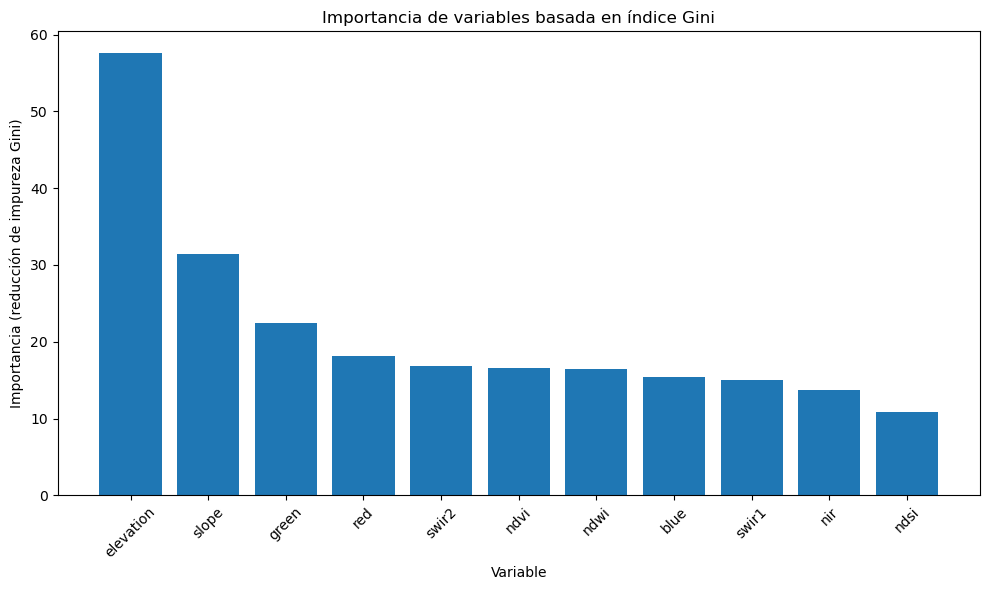


=== Matriz de confusión para el año 2014 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,245,0,5,0,0,0,0
Vegetación,0,229,7,0,0,14,0
Cultivos,10,2,237,0,0,1,0
Nieve,0,0,0,247,0,0,3
Agua,2,0,1,0,247,0,0
Suelo,2,10,1,0,0,236,1
Suelo 2,0,13,0,4,1,0,232



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.98]
1,Vegetación,[0.916]
2,Cultivos,[0.948]
3,Nieve,[0.988]
4,Agua,[0.988]
5,Suelo,[0.944]
6,Suelo 2,[0.928]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9459459459459459, 0.9015748031496063, 0.944..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9560
Coeficiente Kappa: 0.9487
Número de imágenes para el año 2015: 70

=== Validación cruzada para el año 2015 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9126760563380282, 0.927536231884058, 0.9601139601139601, 0.9315476190476191, 0.9228650137741047]
Kappas por fold: [0.8980442657426881, 0.915465210871419, 0.9532480876812421, 0.9200719848583574, 0.9098512599004852]
Accuracy promedio: 0.9309
Kappa promedio: 0.9193

=== Importancia de variables para el año 2015 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,59.691135
8,slope,29.093499
5,ndwi,23.223898
6,nir,20.008668
4,ndvi,19.802167
0,blue,18.600773
2,green,16.979604
10,swir2,16.323290
3,ndsi,15.940879
9,swir1,12.397151


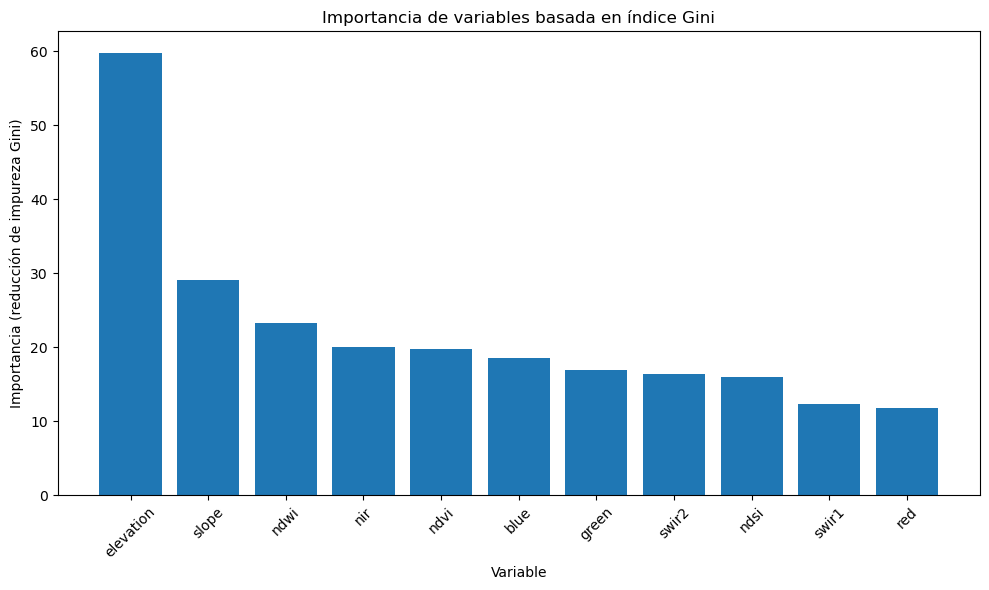


=== Matriz de confusión para el año 2015 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,244,0,6,0,0,0,0
Vegetación,0,222,7,0,2,17,2
Cultivos,4,3,243,0,0,0,0
Nieve,0,0,0,245,1,0,4
Agua,0,0,0,0,250,0,0
Suelo,1,12,0,0,1,235,1
Suelo 2,0,15,0,4,0,0,231



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.976]
1,Vegetación,[0.888]
2,Cultivos,[0.972]
3,Nieve,[0.98]
4,Agua,[1]
5,Suelo,[0.94]
6,Suelo 2,[0.924]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9799196787148594, 0.8809523809523809, 0.949..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9543
Coeficiente Kappa: 0.9467
Número de imágenes para el año 2016: 49

=== Validación cruzada para el año 2016 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9323943661971831, 0.9420289855072463, 0.9544159544159544, 0.9226190476190477, 0.9449035812672176]
Kappas por fold: [0.9210679908468515, 0.9323582464120461, 0.9465956637504754, 0.9096138724496131, 0.93563316222039]
Accuracy promedio: 0.9393
Kappa promedio: 0.9291

=== Importancia de variables para el año 2016 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,61.192268
8,slope,30.208170
5,ndwi,25.547078
4,ndvi,24.659338
6,nir,21.597615
10,swir2,15.749322
7,red,15.123242
9,swir1,13.824303
2,green,13.810350
0,blue,13.224168


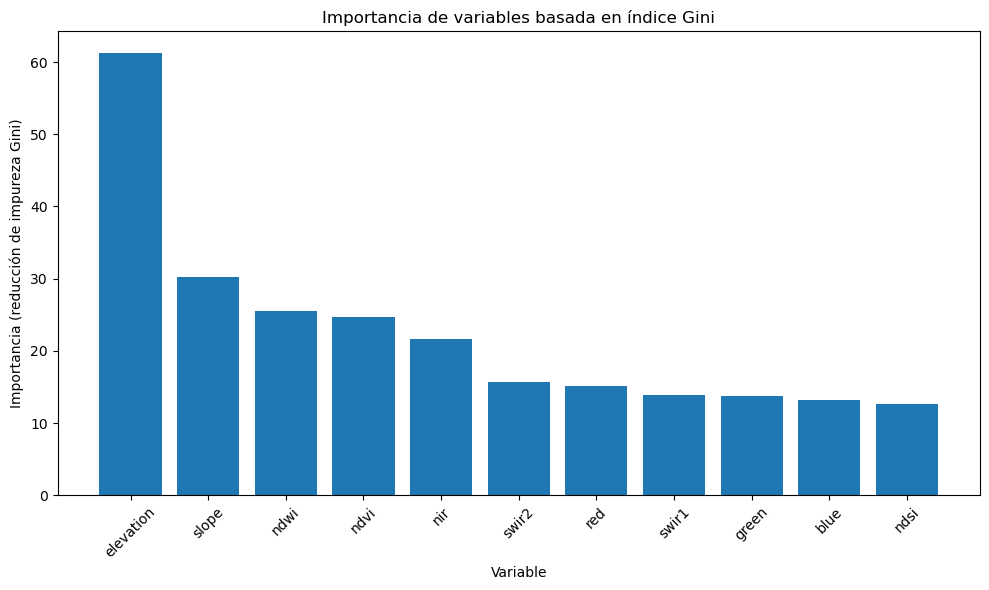


=== Matriz de confusión para el año 2016 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,247,0,3,0,0,0,0
Vegetación,0,226,2,0,0,19,3
Cultivos,6,5,239,0,0,0,0
Nieve,0,0,0,247,0,0,3
Agua,0,0,0,0,250,0,0
Suelo,1,12,1,0,0,235,1
Suelo 2,0,12,0,6,1,0,231



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.988]
1,Vegetación,[0.904]
2,Cultivos,[0.956]
3,Nieve,[0.988]
4,Agua,[1]
5,Suelo,[0.94]
6,Suelo 2,[0.924]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9724409448818898, 0.8862745098039215, 0.975..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9571
Coeficiente Kappa: 0.9500
Número de imágenes para el año 2017: 53

=== Validación cruzada para el año 2017 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9408450704225352, 0.9101449275362319, 0.9458689458689459, 0.9404761904761905, 0.931129476584022]
Kappas por fold: [0.9309197724198001, 0.8951727517765253, 0.9365449390093057, 0.9304822791881323, 0.9195785294612869]
Accuracy promedio: 0.9337
Kappa promedio: 0.9225

=== Importancia de variables para el año 2017 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,69.189838
8,slope,33.290899
10,swir2,20.549192
5,ndwi,20.251512
4,ndvi,19.859411
2,green,18.425045
6,nir,18.376719
0,blue,18.016612
7,red,14.999366
9,swir1,14.536359


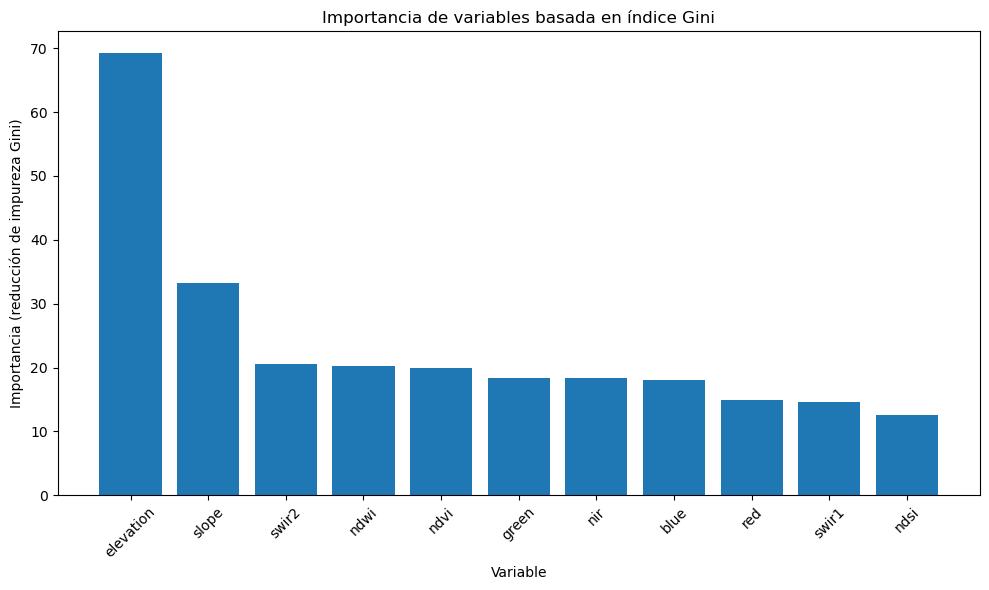


=== Matriz de confusión para el año 2017 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,238,0,12,0,0,0,0
Vegetación,1,225,1,0,0,19,4
Cultivos,6,4,240,0,0,0,0
Nieve,0,0,0,248,0,0,2
Agua,0,0,1,0,249,0,0
Suelo,0,12,2,0,0,235,1
Suelo 2,0,10,0,8,2,0,230



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.952]
1,Vegetación,[0.9]
2,Cultivos,[0.96]
3,Nieve,[0.992]
4,Agua,[0.996]
5,Suelo,[0.94]
6,Suelo 2,[0.92]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9714285714285714, 0.896414342629482, 0.9375..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9514
Coeficiente Kappa: 0.9433
Número de imágenes para el año 2018: 74

=== Validación cruzada para el año 2018 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9352112676056338, 0.9159420289855073, 0.9601139601139601, 0.9375, 0.9256198347107438]
Kappas por fold: [0.9243540213272556, 0.9019377223676085, 0.9532485324758109, 0.927006393147539, 0.9131016872511903]
Accuracy promedio: 0.9349
Kappa promedio: 0.9239

=== Importancia de variables para el año 2018 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,56.097811
8,slope,32.105071
2,green,22.473862
0,blue,19.710969
5,ndwi,18.023065
7,red,17.885587
10,swir2,16.214749
3,ndsi,14.756553
4,ndvi,13.645283
6,nir,12.276495


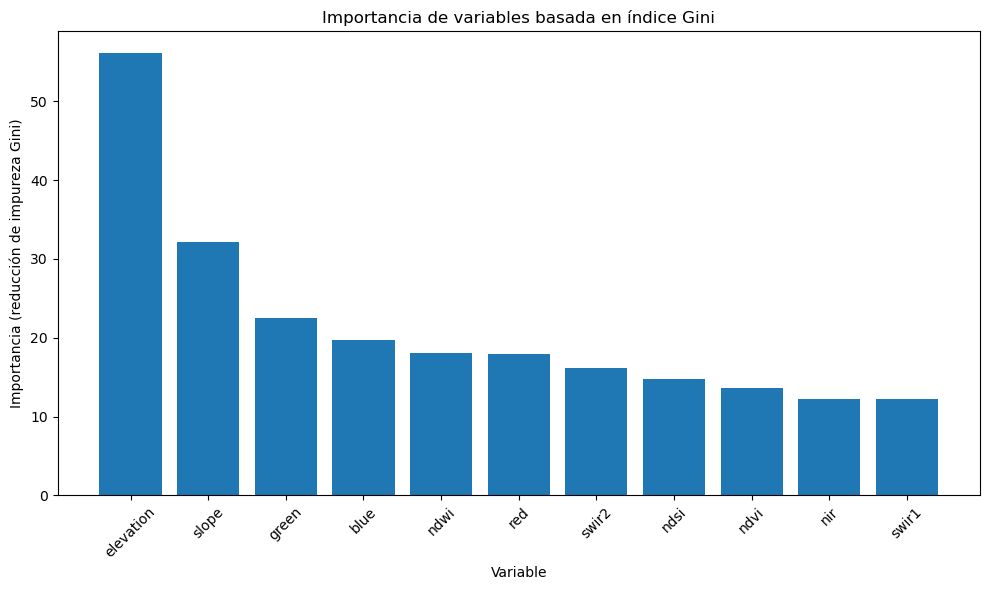


=== Matriz de confusión para el año 2018 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,234,0,16,0,0,0,0
Vegetación,0,229,2,0,0,19,0
Cultivos,3,4,243,0,0,0,0
Nieve,0,0,0,249,0,0,1
Agua,1,0,2,0,247,0,0
Suelo,0,13,2,0,0,235,0
Suelo 2,0,11,0,7,1,0,231



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.936]
1,Vegetación,[0.916]
2,Cultivos,[0.972]
3,Nieve,[0.996]
4,Agua,[0.988]
5,Suelo,[0.94]
6,Suelo 2,[0.924]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9831932773109243, 0.8910505836575876, 0.916..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9531
Coeficiente Kappa: 0.9453
Número de imágenes para el año 2019: 62

=== Validación cruzada para el año 2019 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9352112676056338, 0.9217391304347826, 0.9515669515669516, 0.9494047619047619, 0.928374655647383]
Kappas por fold: [0.9243792429588877, 0.9086970585064152, 0.9432292806378263, 0.9409209383145091, 0.9163305289846723]
Accuracy promedio: 0.9373
Kappa promedio: 0.9267

=== Importancia de variables para el año 2019 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,61.286135
8,slope,28.804339
5,ndwi,19.734372
7,red,19.643873
0,blue,19.629959
2,green,16.924111
6,nir,16.606354
4,ndvi,15.564406
10,swir2,13.681064
3,ndsi,13.227758


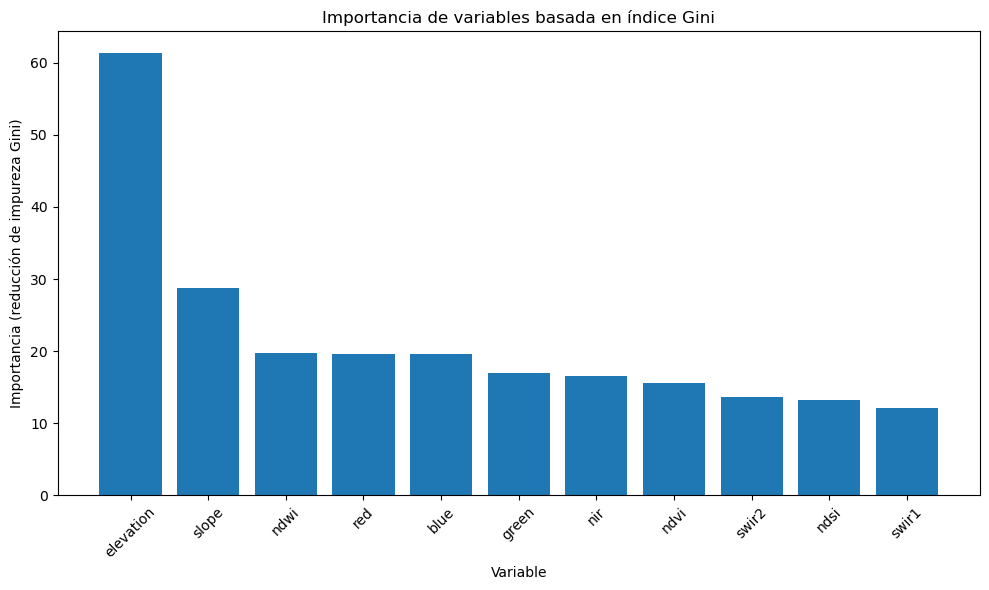


=== Matriz de confusión para el año 2019 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,240,0,10,0,0,0,0
Vegetación,0,227,3,0,0,17,3
Cultivos,9,4,237,0,0,0,0
Nieve,0,0,0,245,0,0,5
Agua,2,0,2,0,246,0,0
Suelo,0,19,3,0,0,228,0
Suelo 2,0,10,0,2,2,0,236



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.96]
1,Vegetación,[0.908]
2,Cultivos,[0.948]
3,Nieve,[0.98]
4,Agua,[0.984]
5,Suelo,[0.912]
6,Suelo 2,[0.944]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9561752988047809, 0.8730769230769231, 0.929..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9480
Coeficiente Kappa: 0.9393
Número de imágenes para el año 2020: 75

=== Validación cruzada para el año 2020 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9436619718309859, 0.9101449275362319, 0.9601139601139601, 0.9255952380952381, 0.9393939393939394]
Kappas por fold: [0.9342154028611667, 0.895180970862368, 0.9532494220395582, 0.9131046468324575, 0.9291468521541629]
Accuracy promedio: 0.9358
Kappa promedio: 0.9250

=== Importancia de variables para el año 2020 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,56.425522
8,slope,25.003160
7,red,20.367955
10,swir2,18.102772
5,ndwi,17.731405
4,ndvi,17.685846
0,blue,17.525448
2,green,17.125047
6,nir,16.184191
3,ndsi,13.758619


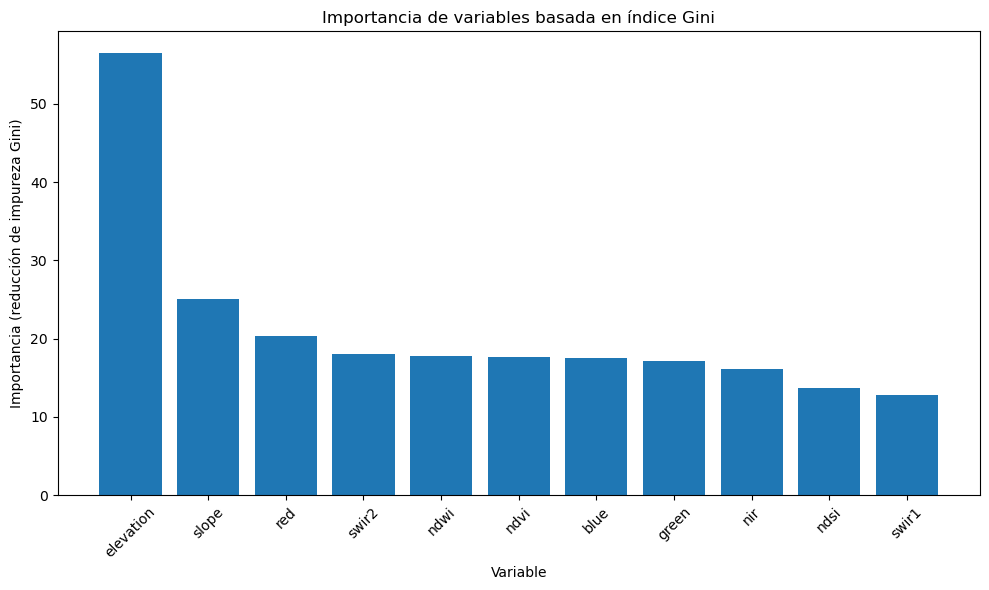


=== Matriz de confusión para el año 2020 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,237,0,13,0,0,0,0
Vegetación,0,226,3,0,1,18,2
Cultivos,0,4,246,0,0,0,0
Nieve,0,0,0,245,0,0,5
Agua,4,0,2,0,244,0,0
Suelo,0,14,3,0,0,233,0
Suelo 2,0,12,0,3,1,0,234



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.948]
1,Vegetación,[0.904]
2,Cultivos,[0.984]
3,Nieve,[0.98]
4,Agua,[0.976]
5,Suelo,[0.932]
6,Suelo 2,[0.936]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.983402489626556, 0.8828125, 0.9213483146067..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9514
Coeficiente Kappa: 0.9433
Número de imágenes para el año 2021: 65

=== Validación cruzada para el año 2021 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9295774647887324, 0.9072463768115943, 0.9629629629629629, 0.9375, 0.9228650137741047]
Kappas por fold: [0.91779895708874, 0.8918272763793492, 0.9565825530943136, 0.9270109235352533, 0.9098960134038988]
Accuracy promedio: 0.9320
Kappa promedio: 0.9206

=== Importancia de variables para el año 2021 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,58.943591
8,slope,32.634961
5,ndwi,21.304721
0,blue,19.582738
7,red,18.436498
2,green,18.193141
10,swir2,18.172977
4,ndvi,17.770703
6,nir,15.619370
3,ndsi,11.289434


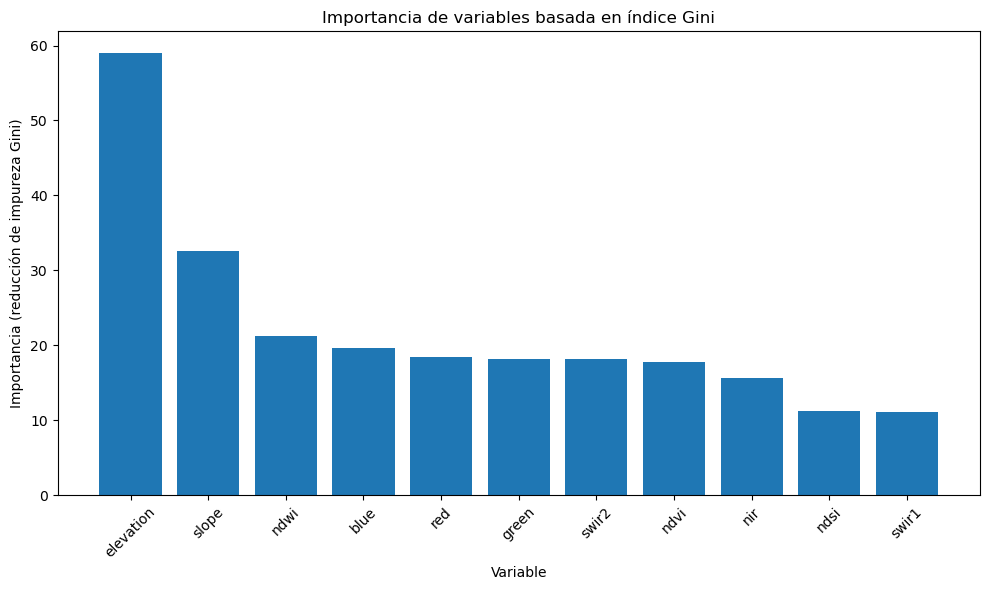


=== Matriz de confusión para el año 2021 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,239,0,11,0,0,0,0
Vegetación,0,232,1,0,0,16,1
Cultivos,5,4,240,0,1,0,0
Nieve,0,0,0,248,0,0,2
Agua,2,0,1,0,247,0,0
Suelo,1,14,1,0,1,233,0
Suelo 2,0,10,0,8,2,1,229



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.956]
1,Vegetación,[0.928]
2,Cultivos,[0.96]
3,Nieve,[0.992]
4,Agua,[0.988]
5,Suelo,[0.932]
6,Suelo 2,[0.916]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9676113360323887, 0.8923076923076924, 0.944..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9531
Coeficiente Kappa: 0.9453
Número de imágenes para el año 2022: 80

=== Validación cruzada para el año 2022 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.952112676056338, 0.927536231884058, 0.9487179487179487, 0.9494047619047619, 0.9338842975206612]
Kappas por fold: [0.944084646672411, 0.9154577533816898, 0.9398720925806083, 0.9409142159651609, 0.922750891131249]
Accuracy promedio: 0.9423
Kappa promedio: 0.9326

=== Importancia de variables para el año 2022 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,53.869681
8,slope,33.816318
0,blue,21.171753
2,green,19.803929
7,red,19.685820
10,swir2,16.023611
4,ndvi,14.419228
5,ndwi,13.885909
9,swir1,13.414887
3,ndsi,13.258163


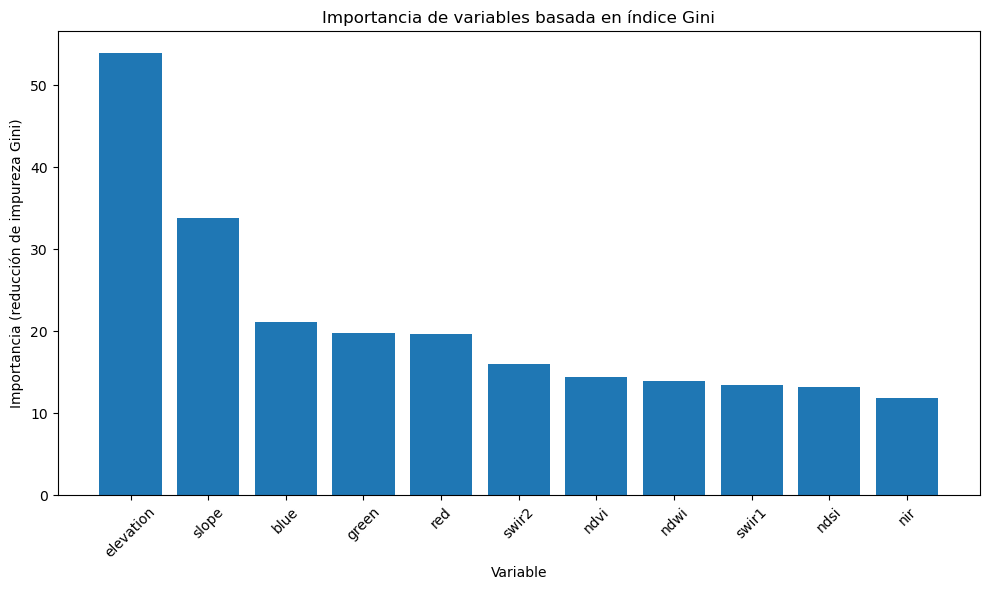


=== Matriz de confusión para el año 2022 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,240,0,10,0,0,0,0
Vegetación,0,231,0,0,1,16,2
Cultivos,7,4,239,0,0,0,0
Nieve,0,0,0,249,0,0,1
Agua,0,0,4,0,246,0,0
Suelo,0,11,1,0,0,238,0
Suelo 2,0,10,0,6,3,1,230



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.96]
1,Vegetación,[0.924]
2,Cultivos,[0.956]
3,Nieve,[0.996]
4,Agua,[0.984]
5,Suelo,[0.952]
6,Suelo 2,[0.92]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.97165991902834, 0.90234375, 0.9409448818897..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9560
Coeficiente Kappa: 0.9487
Número de imágenes para el año 2023: 68

=== Validación cruzada para el año 2023 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9183098591549296, 0.936231884057971, 0.9487179487179487, 0.9404761904761905, 0.931129476584022]
Kappas por fold: [0.9046211714132187, 0.9256268801505099, 0.9398869669463948, 0.9304966592888319, 0.9195507251515903]
Accuracy promedio: 0.9350
Kappa promedio: 0.9240

=== Importancia de variables para el año 2023 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,69.290281
8,slope,36.814548
5,ndwi,28.449732
4,ndvi,23.296010
0,blue,19.555325
6,nir,18.616906
10,swir2,18.096194
7,red,16.481672
3,ndsi,15.109007
9,swir1,14.131608


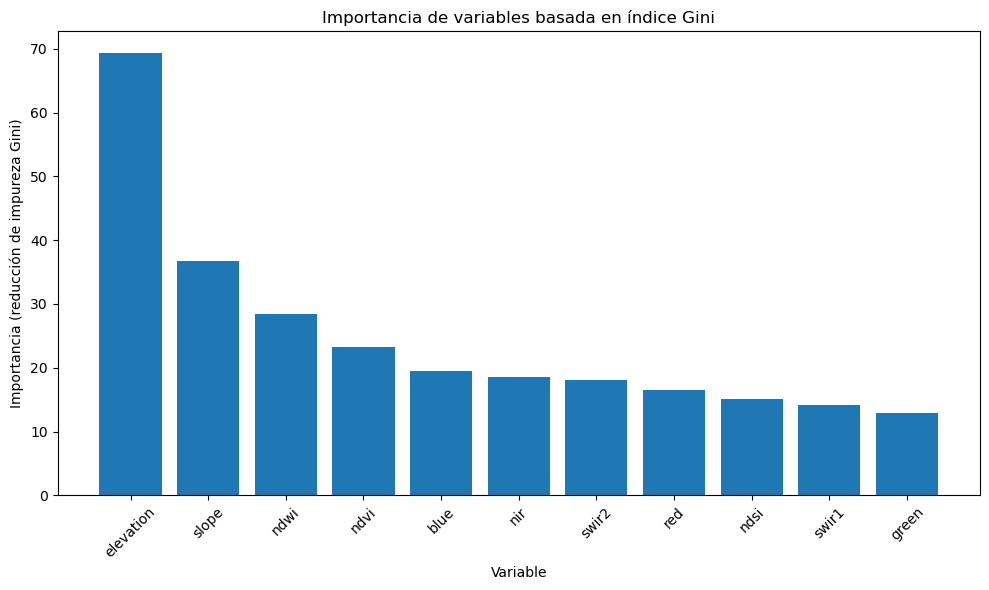


=== Matriz de confusión para el año 2023 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,235,0,14,0,1,0,0
Vegetación,0,233,1,0,1,14,1
Cultivos,4,4,242,0,0,0,0
Nieve,0,0,0,249,0,0,1
Agua,2,0,2,0,246,0,0
Suelo,0,12,2,0,1,235,0
Suelo 2,0,12,0,8,2,1,227



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.94]
1,Vegetación,[0.932]
2,Cultivos,[0.968]
3,Nieve,[0.996]
4,Agua,[0.984]
5,Suelo,[0.94]
6,Suelo 2,[0.908]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.975103734439834, 0.89272030651341, 0.927203..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9526
Coeficiente Kappa: 0.9447
Número de imágenes para el año 2024: 73

=== Validación cruzada para el año 2024 ===
Resultados de la Validación Cruzada:
Accuracies por fold: [0.9492957746478873, 0.927536231884058, 0.9629629629629629, 0.9464285714285714, 0.9669421487603306]
Kappas por fold: [0.9408141527346825, 0.9154892316133963, 0.9565577516280132, 0.9374288729334354, 0.9613682520819108]
Accuracy promedio: 0.9506
Kappa promedio: 0.9423

=== Importancia de variables para el año 2024 ===
Importancia de variables (basada en reducción de impureza Gini):


,Variable,Importancia
1,elevation,41.747469
8,slope,28.566236
3,ndsi,18.831670
2,green,18.533459
0,blue,18.309629
10,swir2,16.799809
7,red,16.794513
5,ndwi,14.877151
4,ndvi,13.132788
9,swir1,11.916321


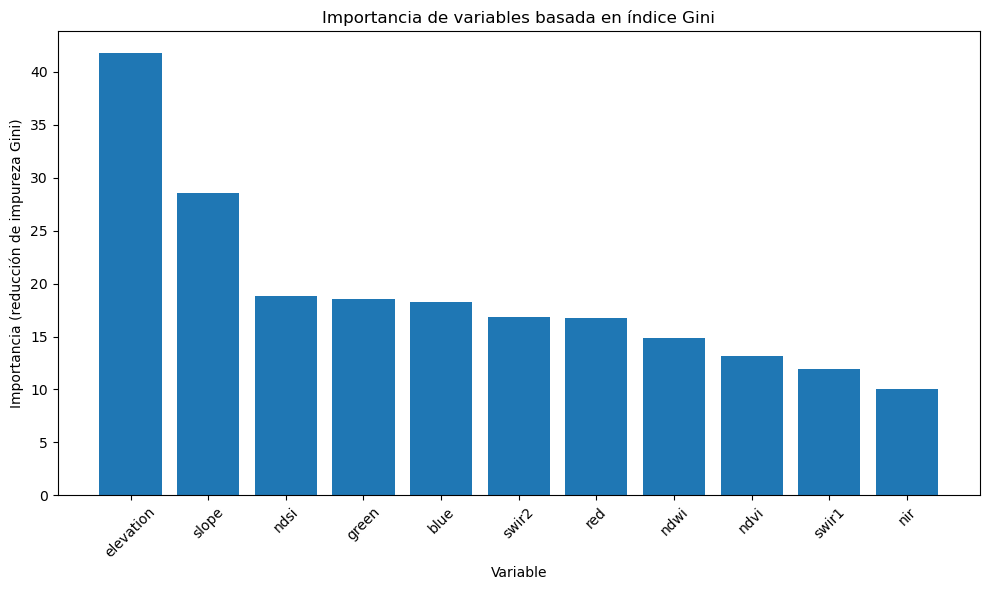


=== Matriz de confusión para el año 2024 ===
Matriz de Confusión:


,Urbano,Vegetación,Cultivos,Nieve,Agua,Suelo,Suelo 2
Urbano,244,0,6,0,0,0,0
Vegetación,0,249,1,0,0,0,0
Cultivos,6,5,237,0,0,2,0
Nieve,0,0,0,249,0,0,1
Agua,2,1,4,0,243,0,0
Suelo,8,1,2,0,0,238,1
Suelo 2,0,15,0,6,2,0,227



Precisión por clase (Producer's Accuracy):


,Clase,Precisión (Producer's Accuracy)
0,Urbano,[0.976]
1,Vegetación,[0.996]
2,Cultivos,[0.948]
3,Nieve,[0.996]
4,Agua,[0.972]
5,Suelo,[0.952]
6,Suelo 2,[0.908]



Exhaustividad por clase (Consumer's Accuracy/Recall):


,Clase,Exhaustividad (Consumer's Accuracy/Recall)
0,Urbano,"[0.9384615384615385, 0.9188191881918819, 0.948..."
1,Vegetación,None
2,Cultivos,None
3,Nieve,None
4,Agua,None
5,Suelo,None
6,Suelo 2,None



Exactitud global (Overall Accuracy): 0.9640
Coeficiente Kappa: 0.9580
Tarea de exportación iniciada para el año 2013
Tarea de exportación iniciada para el año 2014
Tarea de exportación iniciada para el año 2015
Tarea de exportación iniciada para el año 2016
Tarea de exportación iniciada para el año 2017
Tarea de exportación iniciada para el año 2018
Tarea de exportación iniciada para el año 2019
Tarea de exportación iniciada para el año 2020
Tarea de exportación iniciada para el año 2021
Tarea de exportación iniciada para el año 2022
Tarea de exportación iniciada para el año 2023
Tarea de exportación iniciada para el año 2024


In [18]:
# Aplicar la función a cada año
clasificaciones = []
for año in años:
    resultado = clasificarAño(año)
    if resultado is not None:  # Solo añadir años con imágenes disponibles
        clasificaciones.append(resultado)

# Definir paleta de colores para la visualización
palette = [
    '#FF0000',  # urbano - rojo
    '#00FF00',  # vegetación - verde
    '#FFFF00',  # cultivos - amarillo
    '#FFFFFF',  # nieve - blanco
    '#0000FF',  # agua - azul
    '#FF9900',  # suelo - naranja
    '#994C00'   # suelo2 - marrón
]

# Visualizar las clasificaciones en el mapa
for i, classifiedROI in enumerate(clasificaciones):
    año = classifiedROI.get('year').getInfo()
    Map.addLayer(classifiedROI, {'min': 0, 'max': 6, 'palette': palette}, f'Clasificación {año}')

# Añadir selector de capas al mapa
Map.add_layer_control()

# Exportar resultados (opcional)
for i, classifiedROI in enumerate(clasificaciones):
    año = classifiedROI.get('year').getInfo()
    task = ee.batch.Export.image.toDrive(
        image=classifiedROI,
        description=f'Clasificacion_{año}',
        folder='EarthEngine',
        region=roi,
        scale=30,
        maxPixels=1e13
    )
    task.start()
    print(f'Tarea de exportación iniciada para el año {año}')

In [19]:
display(Map)

Map(center=[-36.60356114299189, -71.94760206715752], controls=(WidgetControl(options=['position', 'transparent…